# Lab 6: Multiclass Classification

In Labs 1 and 2, we worked on **binary classification** — predicting one of two classes. But many real-world problems have more than two categories!

**In this lab**, we'll extend our knowledge to **multiclass classification** — predicting one of many classes.

**Examples of multiclass classification:**
- Image classification: Cat, Dog, Bird, or Fish?
- Digit recognition: 0, 1, 2, ..., 9?
- Sentiment analysis: Positive, Neutral, or Negative?

**Our goal**: Build a model that can classify data into one of N classes (where N > 2).

## Binary vs Multiclass Classification

| Aspect | Binary | Multiclass |
|--------|--------|------------|
| Classes | 2 | 3 or more |
| Output | 1 value (probability of class 1) | N values (probability of each class) |
| Output Activation | Sigmoid | Softmax |
| Loss Function | BCEWithLogitsLoss | CrossEntropyLoss |
| Label Type | Float (0.0 or 1.0) | Long/Int (0, 1, 2, ...) |
| Prediction | `round(sigmoid(logits))` | `softmax(logits).argmax()` |

## Install Dependencies

First, let's install the required libraries.

In [23]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cpu


In [24]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


## 1. Creating Multiclass Data

We'll use `make_blobs` from scikit-learn to create clusters of points. Each cluster represents a different class.

**Parameters:**
- `n_samples=1000`: Total number of samples
- `n_features=2`: 2D data for visualization
- `centers=4`: 4 different classes
- `cluster_std=1.5`: Spread of each cluster

In [25]:
# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

print(f"X shape: {X_blob.shape}")
print(f"y shape: {y_blob.shape}")
print(f"\nUnique classes: {np.unique(y_blob)}")
print(f"\nFirst 5 samples:")
print(f"X: {X_blob[:5]}")
print(f"y: {y_blob[:5]}")

X shape: (1000, 2)
y shape: (1000,)

Unique classes: [0 1 2 3]

First 5 samples:
X: [[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]]
y: [3 2 2 1 1]


### Convert to Tensors

Note: For multiclass classification, labels should be `LongTensor` (integers), not floats.

In [43]:
# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)  # Long for class indices!

# এটা সবচেয়ে important line classification-এর জন্য।
# y_blob হলো labels (0, 1, 2 … class index)
# .LongTensor = int64 tensor
# 🧠 কেন LongTensor লাগবে?
# কারণ তুমি যখন nn.CrossEntropyLoss() ব্যবহার করো, তখন:
# Target (y) হতে হবে class index আকারে, float না!

print(f"X dtype: {X_blob.dtype}")
print(f"y dtype: {y_blob.dtype}")

TypeError: expected np.ndarray (got Tensor)

### Split into Train and Test Sets

In [27]:
# Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

print(f"Training samples: {len(X_blob_train)}")
print(f"Test samples: {len(X_blob_test)}")

Training samples: 800
Test samples: 200


### Visualize the Data

Let's plot our 4-class data. Each color represents a different class.

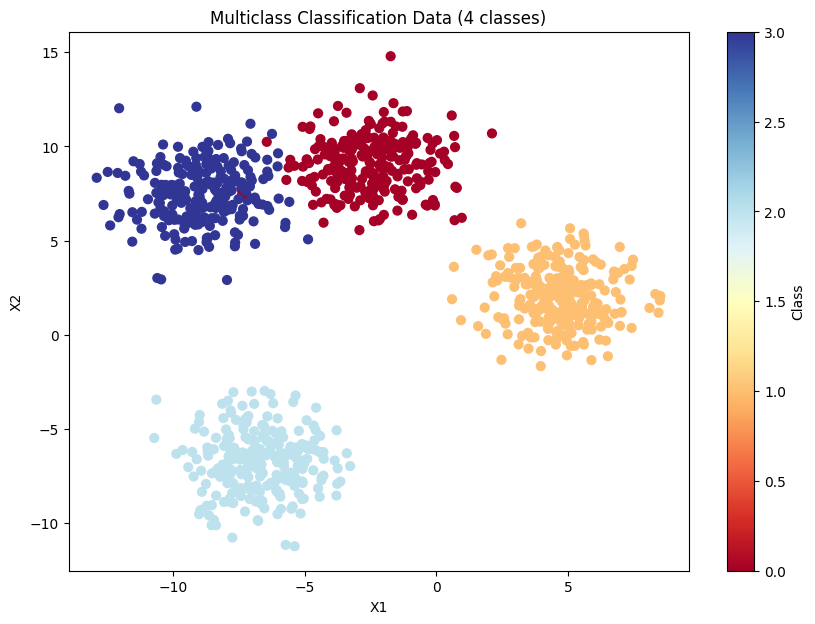

In [28]:
# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu, s=40)
plt.title(f"Multiclass Classification Data ({NUM_CLASSES} classes)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Class")
plt.show()

## 2. Building a Multiclass Classification Model

Our model is similar to Lab 2, but with a key difference in the output layer:

**Binary (Lab 2):** Output = 1 (probability of being class 1)  
**Multiclass:** Output = NUM_CLASSES (probability for each class)

**Model Architecture:**
- Input: 2 features
- Hidden: 8 neurons (x2 layers)
- Output: 4 values (one per class)

In [29]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Multiclass classification model.

        Args:
            input_features: Number of input features (2 for our 2D data)
            output_features: Number of output classes (4 for our data)
            hidden_units: Neurons in hidden layers
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create model instance
model = BlobModel(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=8)
print(model)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


## 3. Loss Function and Optimizer

For multiclass classification, we use:

**Loss: `nn.CrossEntropyLoss()`**
- Combines softmax and negative log likelihood
- Works with raw logits (no need to apply softmax manually)
- Expects class indices (0, 1, 2, 3) not one-hot encoded

**Optimizer: SGD**
- Standard gradient descent with learning rate 0.1

In [30]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

print(f"Loss function: {loss_fn}")
print(f"Optimizer: {optimizer}")

Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Accuracy Function

In [31]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions."""
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 4. Understanding Softmax and Model Outputs

Before training, let's understand how multiclass predictions work.

**The pipeline:**
1. **Logits**: Raw model output (can be any value)
2. **Softmax**: Converts to probabilities (0-1, sum to 1)
3. **Argmax**: Picks the class with highest probability

In [32]:
# Let's see what the untrained model outputs
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test[:5])

print("Raw logits (model output):")
print(y_logits)
print(f"\nShape: {y_logits.shape} (5 samples, 4 classes)")

Raw logits (model output):
tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

Shape: torch.Size([5, 4]) (5 samples, 4 classes)


In [33]:
# Apply softmax to get probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print("Prediction probabilities (after softmax):")
print(y_pred_probs)
print(f"\nSum of probabilities per sample: {y_pred_probs.sum(dim=1)}")

Prediction probabilities (after softmax):
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

Sum of probabilities per sample: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Notice how each row sums to 1.0 — that's what softmax does! It converts logits into a probability distribution over classes.

In [34]:
# Get predicted class using argmax
# argmax মানে → সবচেয়ে বড় মানটার index বের করো
# dim=1 মানে → প্রতিটা row (প্রতিটা sample) এর মধ্যে

y_preds = y_pred_probs.argmax(dim=1)

print("Predicted classes (argmax):")
print(y_preds)

print("\nActual classes:")
print(y_blob_test[:5])

Predicted classes (argmax):
tensor([1, 0, 0, 0, 0])

Actual classes:
tensor([1, 3, 2, 1, 0])


### Detailed Example

Let's look at one sample in detail:

In [35]:
# Detailed look at first sample
print("First sample probabilities:")
for i, prob in enumerate(y_pred_probs[0]):
    print(f"  Class {i}: {prob:.4f} ({prob*100:.2f}%)")

print(f"\nPredicted class: {torch.argmax(y_pred_probs[0]).item()}")
print(f"Actual class: {y_blob_test[0].item()}")

First sample probabilities:
  Class 0: 0.3169 (31.69%)
  Class 1: 0.3244 (32.44%)
  Class 2: 0.1405 (14.05%)
  Class 3: 0.2182 (21.82%)

Predicted class: 1
Actual class: 1


## 5. Training the Model

The training loop is similar to previous labs, with one key difference in how we make predictions:

**Binary:** `y_pred = torch.round(torch.sigmoid(logits))`
**Multiclass:** `y_pred = torch.softmax(logits, dim=1).argmax(dim=1)`

The training loop follows these 5 steps:

1. Zero gradients
2. Forward pass
3. Calculate loss
4. Backward pass (backpropagation)
5. Optimizer step

![Neural Network Training Flow](https://raw.githubusercontent.com/poridhiEng/lab-asset/180b5d3f8ff55ed46357e14dce40bde6ae94645d/tensorcode/Deep-learning-with-pytorch/Classification/Lab_03/images/infra-8.svg)

The diagram above illustrates the complete training pipeline for our multiclass classifier. Data flows forward through multiple hidden layers with ReLU activations, producing 4 outputs (one per class). The CrossEntropyLoss computes the error, gradients flow backward through the network, and SGD updates the weights. This cycle repeats each epoch until the model converges.

In [36]:
# Fit the model
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Zero gradients
    optimizer.zero_grad()

    # 2. Forward pass
    y_logits = model(X_blob_train)  # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # logits -> probs -> labels

    # 3. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)  # CrossEntropyLoss expects raw logits
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


## 6. Evaluating the Model

Let's make final predictions and evaluate the model's performance.

In [37]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# Convert logits to predictions
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

# Calculate accuracy
final_acc = accuracy_fn(y_true=y_blob_test, y_pred=y_preds)
print(f"Final Test Accuracy: {final_acc:.2f}%")

# Show some predictions
print(f"\nFirst 10 predictions: {y_preds[:10].tolist()}")
print(f"First 10 actual:      {y_blob_test[:10].tolist()}")

Final Test Accuracy: 99.50%

First 10 predictions: [1, 3, 2, 1, 0, 3, 2, 0, 2, 0]
First 10 actual:      [1, 3, 2, 1, 0, 3, 2, 0, 2, 0]


## 7. Visualizing Decision Boundaries

Let's see how our model divides the feature space into 4 regions, one for each class.

In [38]:
def plot_decision_boundary_multiclass(model, X, y):
    """Plots decision boundaries for multiclass classification."""
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Multiclass: use softmax + argmax
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

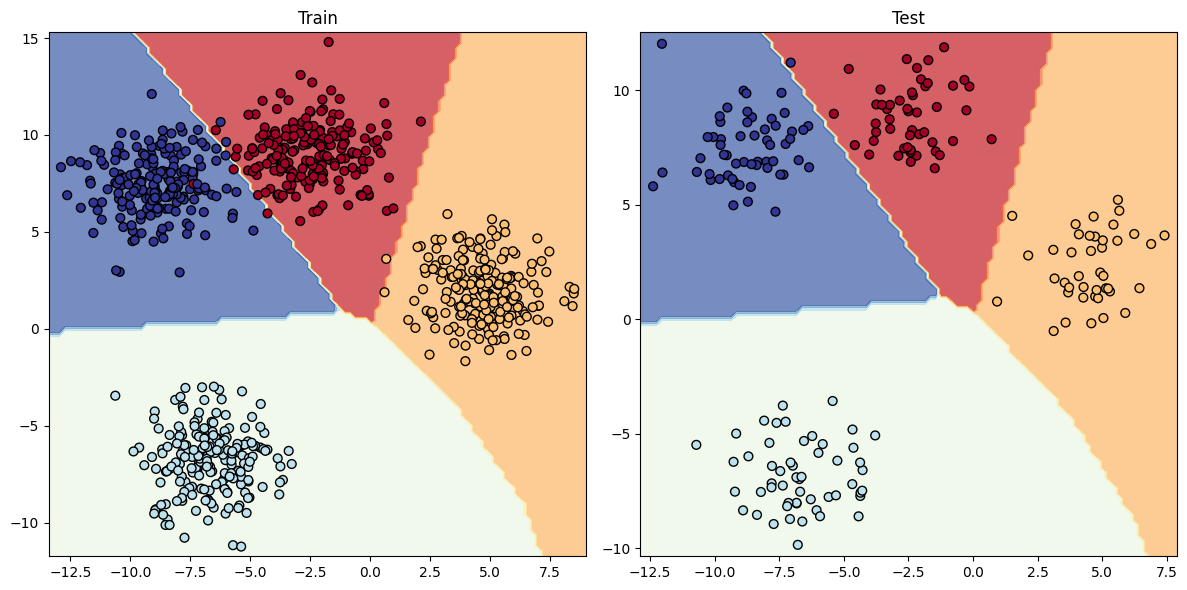

In [39]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary_multiclass(model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary_multiclass(model, X_blob_test, y_blob_test)

plt.tight_layout()
plt.show()

The model has learned to divide the space into 4 regions, with each region corresponding to one class!

## 8. Understanding the Predictions in Detail

Let's look at a few samples to understand how the model makes decisions.

In [40]:
# Get predictions for a few samples
model.eval()
with torch.inference_mode():
    sample_logits = model(X_blob_test[:3])
    sample_probs = torch.softmax(sample_logits, dim=1)
    sample_preds = sample_probs.argmax(dim=1)

# Display detailed predictions
for i in range(3):
    print(f"\n=== Sample {i+1} ===")
    print(f"Features: X1={X_blob_test[i][0]:.2f}, X2={X_blob_test[i][1]:.2f}")
    print(f"Actual class: {y_blob_test[i].item()}")
    print(f"Predicted class: {sample_preds[i].item()}")
    print("Probabilities:")
    for j in range(NUM_CLASSES):
        bar = "█" * int(sample_probs[i][j] * 20)
        print(f"  Class {j}: {sample_probs[i][j]:.4f} {bar}")


=== Sample 1 ===
Features: X1=4.67, X2=4.49
Actual class: 1
Predicted class: 1
Probabilities:
  Class 0: 0.0013 
  Class 1: 0.9987 ███████████████████
  Class 2: 0.0000 
  Class 3: 0.0000 

=== Sample 2 ===
Features: X1=-8.00, X2=6.88
Actual class: 3
Predicted class: 3
Probabilities:
  Class 0: 0.0050 
  Class 1: 0.0001 
  Class 2: 0.0011 
  Class 3: 0.9939 ███████████████████

=== Sample 3 ===
Features: X1=-6.28, X2=-7.86
Actual class: 2
Predicted class: 2
Probabilities:
  Class 0: 0.0014 
  Class 1: 0.0009 
  Class 2: 0.9946 ███████████████████
  Class 3: 0.0031 


## 9. Experimenting with More Classes

Let's try with more classes to see how the model adapts!

In [41]:
# Create data with 6 classes
NUM_CLASSES_NEW = 6

X_new, y_new = make_blobs(n_samples=1000,
                          n_features=2,
                          centers=NUM_CLASSES_NEW,
                          cluster_std=1.2,
                          random_state=42)

X_new = torch.from_numpy(X_new).type(torch.float)
y_new = torch.from_numpy(y_new).type(torch.LongTensor)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.2, random_state=42
)

# Create and train model
model_new = BlobModel(input_features=2, output_features=NUM_CLASSES_NEW, hidden_units=8)
optimizer_new = torch.optim.SGD(model_new.parameters(), lr=0.1)

torch.manual_seed(42)
for epoch in range(100):
    model_new.train()
    y_logits = model_new(X_train_new)
    loss = loss_fn(y_logits, y_train_new)
    optimizer_new.zero_grad()
    loss.backward()
    optimizer_new.step()

# Evaluate
model_new.eval()
with torch.inference_mode():
    test_logits = model_new(X_test_new)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = accuracy_fn(y_test_new, test_preds)

print(f"6-Class Model Test Accuracy: {test_acc:.2f}%")

6-Class Model Test Accuracy: 75.00%


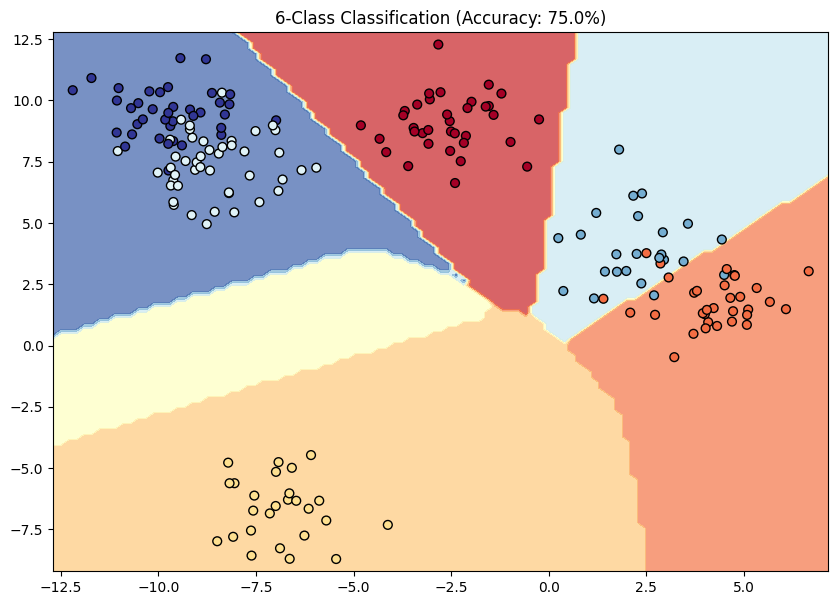

In [42]:
# Visualize 6-class decision boundary
plt.figure(figsize=(10, 7))
plt.title(f"6-Class Classification (Accuracy: {test_acc:.1f}%)")
plot_decision_boundary_multiclass(model_new, X_test_new, y_test_new)
plt.show()

The same model architecture works for any number of classes — just change the output layer size!

## 10. Conclusion

Congratulations on completing Lab 3 and the entire classification series!

### What We Achieved

In this lab, we extended our binary classification knowledge to **multiclass classification**:

1. **Created multiclass data** using `make_blobs` with 4 classes
2. **Built a multiclass model** with output size = number of classes
3. **Used CrossEntropyLoss** for multiclass classification
4. **Applied softmax** to convert logits to probabilities
5. **Used argmax** to get the predicted class
6. **Visualized decision boundaries** showing multiple regions
7. **Experimented with 6 classes** to show flexibility

### Key Takeaways

1. **Multiclass classification** predicts one of N classes (N > 2)
2. **Softmax** converts logits to probabilities that sum to 1
3. **CrossEntropyLoss** combines softmax and negative log likelihood
4. **Argmax** selects the class with highest probability
5. The same model architecture scales to any number of classes

### Project Complete!

Congratulations! You've completed all 3 classification labs:
- **Lab 1**: Binary classification basics (linear model fails)
- **Lab 2**: Adding ReLU for non-linear patterns (high accuracy)
- **Lab 3**: Multiclass classification with softmax

You now have a solid foundation in PyTorch classification!